In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import datetime
import tensorflow as tf

# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [4]:
def plot_time_series_data_window(
  x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")
        
  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

### Load

In [5]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [6]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [7]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


In [8]:
df_E = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "E"].copy()
df_E

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
5,2021-01-04,DEVRYNALDO RIZAL,JL JEND A YANI,KARANG JATI,BALIKPAPAN TENGAH,LAKI-LAKI,1978-12-18,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SARJANA,ES5,E,INDIVIDU,46
7,2021-01-04,SUPARYANTO,JL KESATRIA PERUM NUSANTARA LESTARI,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1976-08-27,NaN,NaN,NaN,ES4,E,INSTANSI LUAR,48
14,2021-01-06,MULYADI,JL SYARIFUDIN YOES,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1974-12-23,Wiraswasta-Konstruksi,"> Rp. 6.000.000,-",SLTA/SMU,ES4,E,INDIVIDU,50
15,2021-01-06,MUHAMMAD FADILLAH,JL AL MAKMUR III,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1997-12-07,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTP/SMP,ES4,E,INDIVIDU,27
18,2021-01-06,ANDI WIJAYANTO,JL SUGENG RAWUH II,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-07-06,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ES5,E,INDIVIDU,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,2024-06-30,PT KEMILAU INDAH NUSANTARA,JL. POROS SANGATTA-BENGALON KM. 32,MUARA BENGALON,BENGALON,LAKI-LAKI,1985-06-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,EG2,E,INDIVIDU,39
6523,2024-07-12,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGALON KM 32 SIMPANG RAWA ...,MUARA BENGALON,BENGALON,NaN,2000-11-18,Wiraswasta-Pertambangan,NaN,NaN,EG2,E,INSTANSI LUAR,24
6833,2024-08-29,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGGALON KM 32 SIMPANG RAWA...,MUARA BENGALON,BENGALON,NaN,1992-08-27,NaN,NaN,NaN,EG2,E,INSTANSI LUAR,32
6841,2024-08-31,LINUS HARIMIN,JL BATU RATNA KM 11,KARANG JOANG,BALIKPAPAN UTARA,LAKI-LAKI,1973-09-23,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ESF,E,INDIVIDU,51


In [9]:
df_E_count = df_E[["Tgl. Mohon"]].copy()
df_E_count["count"] = 1.
df_E_count = df_E_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_E_count["cumulative_sum"] = df_E_count["count"].cumsum()
df_E_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,2,2
1,2021-01-06,3,5
2,2021-01-07,1,6
3,2021-01-14,1,7
4,2021-01-21,1,8
...,...,...,...
170,2024-06-05,1,421
171,2024-06-30,1,422
172,2024-07-12,1,423
173,2024-08-29,1,424


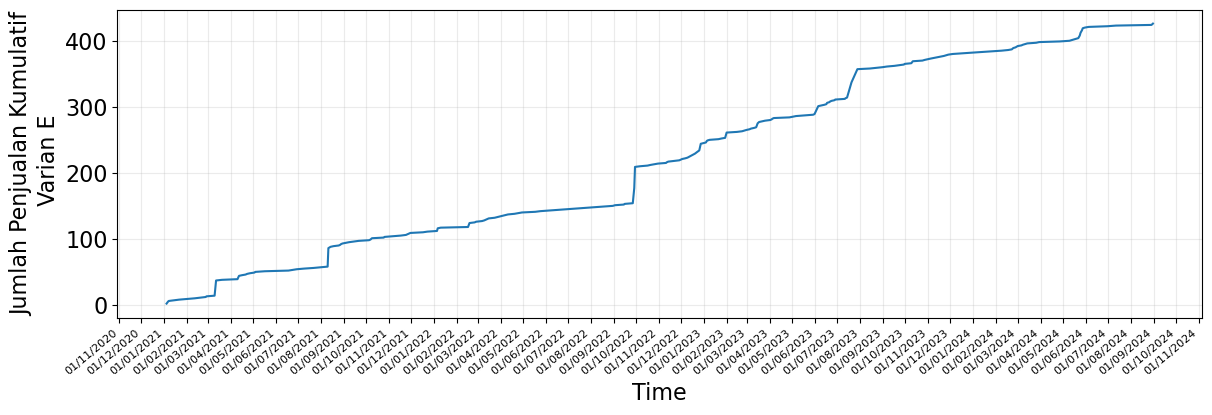

In [10]:
plot_time_series(df_E_count["Tgl. Mohon"], df_E_count["cumulative_sum"], use_year_locator=True, 
                  ylabel="Jumlah Penjualan Kumulatif\n Varian E")

## Feature engineering

In [11]:
df_E_count.describe()

,Tgl. Mohon,count,cumulative_sum
count,175,175.000000,175.000000
mean,2022-10-28 14:40:27.428571392,2.434286,222.862857
min,2021-01-04 00:00:00,1.000000,2.000000
25%,2021-11-25 00:00:00,1.000000,106.500000
50%,2022-12-26 00:00:00,1.000000,234.000000
75%,2023-08-18 12:00:00,2.000000,358.500000
max,2024-08-31 00:00:00,32.000000,426.000000
std,NaN,4.381908,129.754293


- Karena `count` memiliki pola distribusi yang sangat condong ke bawah (skewed right) dan memiliki beberapa outlier, akan sangat penting untuk melakukan pengecekan outlier lebih lanjut
- Kolom `cumulative_sum` tidak cocok untuk digunakan langsung dalam prediksi karena secara definisi selalu meningkat namun bisa digunakan untuk membuat fitur baru seperti jumlah permohonan dalam periode tertentu (sliding window)

Karena outlier pada `count` dapat mengganggu pelatihan model, maka munakan winsorization (membatasi nilai ekstrim) atau normalisasi robust seperti RobustScaler untuk penanganan outlier. Selain itu, `cumulative_sum` bersifat terus meningkat, maka dibuat fitur baru: Jumlah permohonan dalam 7 hari terakhir (rolling_7days) dan Pertumbuhan harian (delta_count = count hari ini - hari sebelumnya).

Normalisasi (Scaling)

Deep learning sensitif terhadap skala fitur.

Gunakan MinMaxScaler, StandardScaler, atau RobustScaler.

### Add Fitur

In [12]:
df_E_rolling = df_E_count.copy()
df_E_rolling = df_E_count.sort_values("Tgl. Mohon").reset_index(drop=True)

df_E_rolling["delta_count"] = df_E_rolling["count"].diff().fillna(0)
df_E_rolling["rolling_7days"] = df_E_rolling["count"].rolling(window=7, min_periods=1).sum()
df_E_rolling

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days
0,2021-01-04,2,2,0.0,2.0
1,2021-01-06,3,5,1.0,5.0
2,2021-01-07,1,6,-2.0,6.0
3,2021-01-14,1,7,0.0,7.0
4,2021-01-21,1,8,0.0,8.0
...,...,...,...,...,...
170,2024-06-05,1,421,0.0,21.0
171,2024-06-30,1,422,0.0,18.0
172,2024-07-12,1,423,0.0,15.0
173,2024-08-29,1,424,0.0,12.0


### Penanganan Outlier

In [13]:
# def winsorize(series, lower=0.01, upper=0.99):
#     lower_bound = series.quantile(lower)
#     upper_bound = series.quantile(upper)
#     return series.clip(lower=lower_bound, upper=upper_bound)

# df_E_winsor = df_E_rolling.copy()
# df_E_winsor["count_winsor"] = winsorize(df_E_winsor["count"])
# df_E_winsor

In [14]:
# scaler = RobustScaler()
# scaled_array = scaler.fit_transform(df_E_winsor[["count_winsor", "delta_count", "rolling_7days"]])
# df_E_scaled = pd.DataFrame(scaled_array, columns=["count_scaled", "delta_scaled", "rolling_scaled"])

# df_E_fix = pd.concat([df_E_winsor[["Tgl. Mohon"]].reset_index(drop=True), df_E_scaled], axis=1)

In [15]:
# scaler = MinMaxScaler()
# scaled_array = scaler.fit_transform(df_E_rolling[["count", "delta_count", "rolling_7days"]])
# df_E_scaled = pd.DataFrame(scaled_array, columns=["count_scaled", "delta_scaled", "rolling_scaled"])

# df_E_fix = pd.concat([df_E_rolling[["Tgl. Mohon"]].reset_index(drop=True), df_E_scaled], axis=1)
# df_E_fix

### Data Splitting

In [16]:
n_data = len(df_E_rolling)

# We drop "date_time" column because we never use it
# But for week-14, we need this column for plotting, so do not drop it
# df_traffic_selected_drop_date_time = df_E_rolling.drop(["date_time"], axis=1)

# Split 70:20:10 (train:validation:set)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)
# train_df = df_traffic_selected_drop_date_time[:idx_train].copy()
# val_df = df_traffic_selected_drop_date_time[idx_train:idx_test].copy()
# test_df = df_traffic_selected_drop_date_time[idx_test:].copy()

train_df = df_E_rolling[:idx_train].copy()
val_df = df_E_rolling[idx_train:idx_test].copy()
test_df = df_E_rolling[idx_test:].copy()


print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (122, 35, 18)


In [17]:
train_df

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days
0,2021-01-04,2,2,0.0,2.0
1,2021-01-06,3,5,1.0,5.0
2,2021-01-07,1,6,-2.0,6.0
3,2021-01-14,1,7,0.0,7.0
4,2021-01-21,1,8,0.0,8.0
...,...,...,...,...,...
117,2023-06-13,2,303,-10.0,21.0
118,2023-06-16,1,304,-1.0,21.0
119,2023-06-17,2,306,1.0,22.0
120,2023-06-20,1,307,-1.0,21.0


C:\Users\TEMP\AppData\Local\Temp\ipykernel_11584\2946062772.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


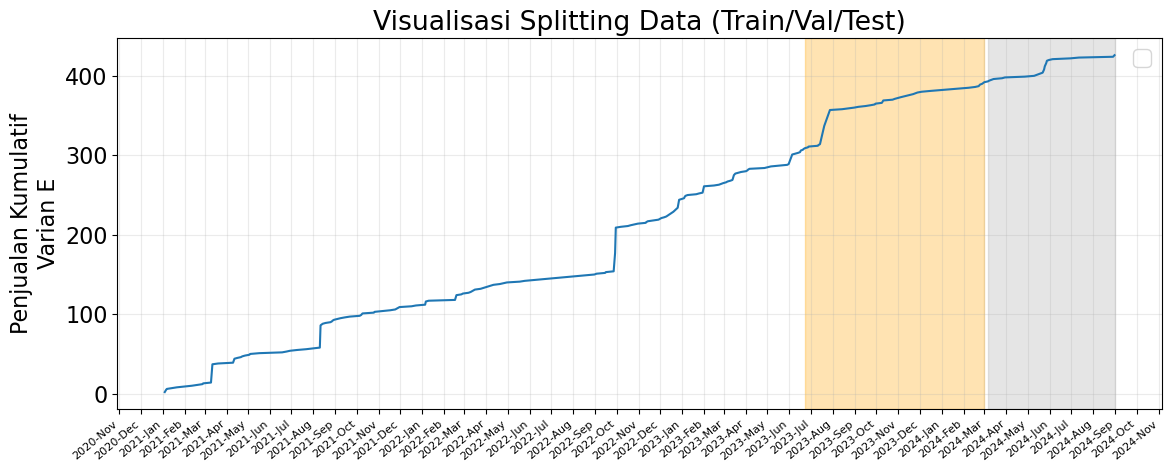

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_E_rolling['Tgl. Mohon'], df_E_rolling["cumulative_sum"])
ax.grid("on")
ax.set_ylabel("Penjualan Kumulatif\nVarian E")
ax.set_title("Visualisasi Splitting Data (Train/Val/Test)")
ax.legend()
# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[-1], 
           color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(8)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


scaling data

In [19]:
column_for_scaling = ["count", "cumulative_sum", "delta_count", "rolling_7days"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

train_scale_df = train_df.copy()
val_scale_df = val_df.copy()
test_scale_df = test_df.copy()

train_scale_df[column_for_scaling] = scaler_obj.transform(train_scale_df[column_for_scaling])
val_scale_df[column_for_scaling] = scaler_obj.transform(val_scale_df[column_for_scaling])
test_scale_df[column_for_scaling] = scaler_obj.transform(test_scale_df[column_for_scaling])

display(train_scale_df.head())
display(val_scale_df.head())
display(test_scale_df.head())

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days
0,2021-01-04,0.032258,0.000000,0.543860,0.000000
1,2021-01-06,0.064516,0.009804,0.561404,0.051724
2,2021-01-07,0.000000,0.013072,0.508772,0.068966
3,2021-01-14,0.000000,0.016340,0.543860,0.086207
4,2021-01-21,0.000000,0.019608,0.543860,0.103448


,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days
122,2023-06-23,0.0,1.003268,0.54386,0.310345
123,2023-06-27,0.0,1.006536,0.54386,0.120690
124,2023-06-28,0.0,1.009804,0.54386,0.103448
125,2023-07-11,0.0,1.013072,0.54386,0.103448
126,2023-07-12,0.0,1.016340,0.54386,0.086207


,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days
157,2024-03-06,0.000000,1.277778,0.526316,0.103448
158,2024-03-08,0.000000,1.281046,0.543860,0.103448
159,2024-03-14,0.032258,1.287582,0.561404,0.120690
160,2024-03-26,0.000000,1.290850,0.526316,0.120690
161,2024-03-30,0.000000,1.294118,0.543860,0.120690


In [20]:
train_scale_df.to_csv("./data/train_scale.csv", index=False)
val_scale_df.to_csv("./data/val_scale.csv", index=False)
test_scale_df.to_csv("./data/test_scale.csv", index=False)

In [21]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[f"{section}_scale_df"] = pd.read_csv(f"./data/{section}_scale.csv",
                                                parse_dates=["Tgl. Mohon"])
dataset["train_scale_df"]

,Tgl. Mohon,count,cumulative_sum,delta_count,rolling_7days
0,2021-01-04,0.032258,0.000000,0.543860,0.000000
1,2021-01-06,0.064516,0.009804,0.561404,0.051724
2,2021-01-07,0.000000,0.013072,0.508772,0.068966
3,2021-01-14,0.000000,0.016340,0.543860,0.086207
4,2021-01-21,0.000000,0.019608,0.543860,0.103448
...,...,...,...,...,...
117,2023-06-13,0.032258,0.983660,0.368421,0.327586
118,2023-06-16,0.000000,0.986928,0.526316,0.327586
119,2023-06-17,0.032258,0.993464,0.561404,0.344828
120,2023-06-20,0.000000,0.996732,0.526316,0.327586


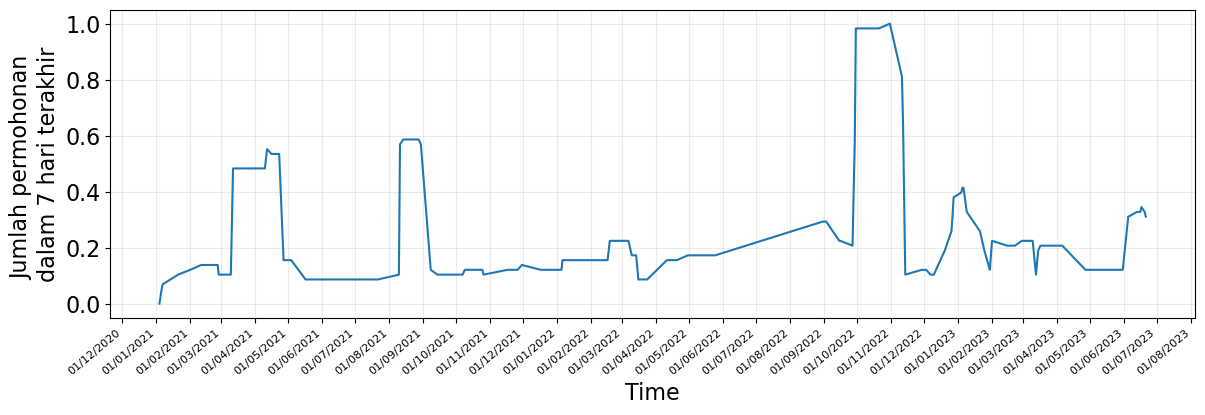

In [22]:
num_of_rows = 200
train_scale_df_selected = dataset["train_scale_df"]
plot_time_series(train_scale_df_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=False, use_year_locator=True,)

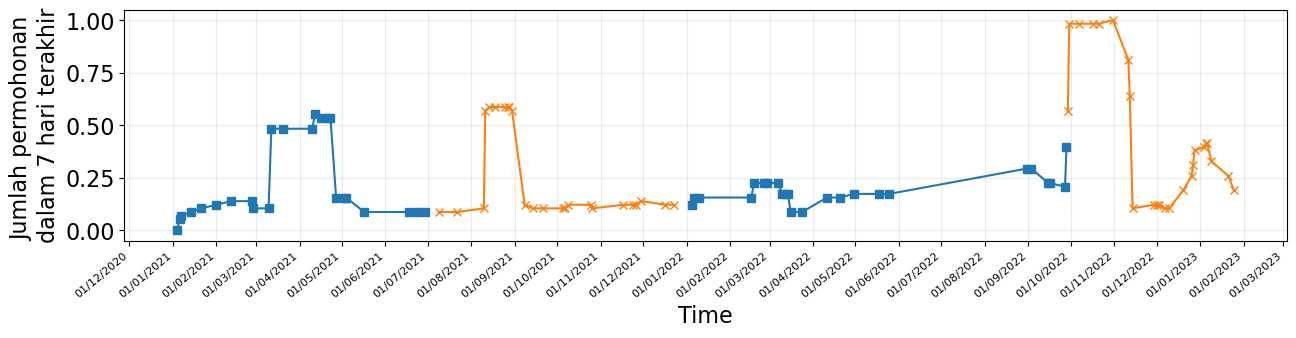

In [23]:
num_of_rows = 200
train_scale_df_selected = dataset["train_scale_df"]
plot_time_series_data_window(train_scale_df_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir", figsize=(15, 3),
                  use_weekday_locator=False, use_year_locator=True,)

## Model Development

In [24]:
feature_col = "rolling_7days"

# Fungsi untuk membuat sequence LSTM
def create_sequences(data_series, sequence_length):
    X, y = [], []
    for i in range(len(data_series) - sequence_length):
        seq = data_series[i:i + sequence_length]
        label = data_series[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

In [25]:
# Set panjang sequence
sequence_length = 10  # Bisa di-tuning

# Ambil data dari dataset scaled yang sudah kamu buat sebelumnya
train_series = dataset["train_scale_df"][feature_col].values
val_series = dataset["val_scale_df"][feature_col].values
test_series = dataset["test_scale_df"][feature_col].values

# Buat sequence
X_train, y_train = create_sequences(train_series, sequence_length)
X_val, y_val = create_sequences(val_series, sequence_length)
X_test, y_test = create_sequences(test_series, sequence_length)

# Reshape ke bentuk [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [26]:
# Bangun model LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Data Training

epoch = 50

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=32, verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 0.0997 - val_loss: 0.0528
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0557 - val_loss: 0.0588
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0589 - val_loss: 0.0729
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0571 - val_loss: 0.0537
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0553 - val_loss: 0.0444
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0517 - val_loss: 0.0415
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0444 - val_loss: 0.0406
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0441 - val_loss: 0.0412
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0386 - val_loss: 0.0437
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0444 - val_loss: 0.0443
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0403 - val_loss: 0.0403
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0338 - val_loss: 0.0360


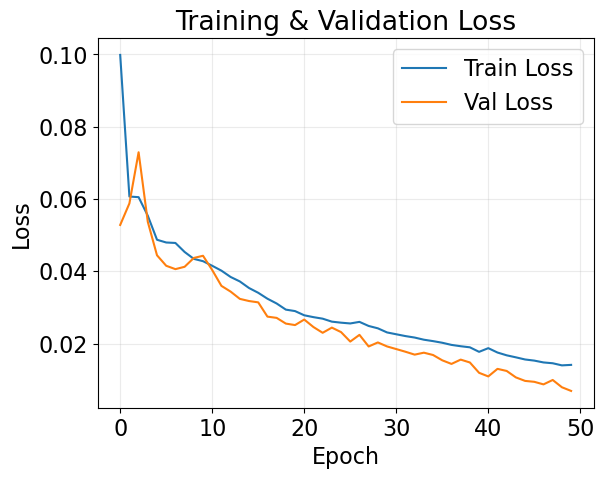

In [28]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
predictions = model.predict(X_test)

dummy_input = np.zeros((predictions.shape[0], len(column_for_scaling)))
rolling_index = column_for_scaling.index("rolling_7days")
dummy_input[:, rolling_index] = predictions[:, 0]

predictions_inverse = scaler_obj.inverse_transform(dummy_input)[:, rolling_index]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


In [ ]:
y_test_dummy = np.zeros((len(y_test), len(column_for_scaling)))
y_test_dummy[:, rolling_index] = y_test

y_test_inverse = scaler_obj.inverse_transform(y_test_dummy)[:, rolling_index]


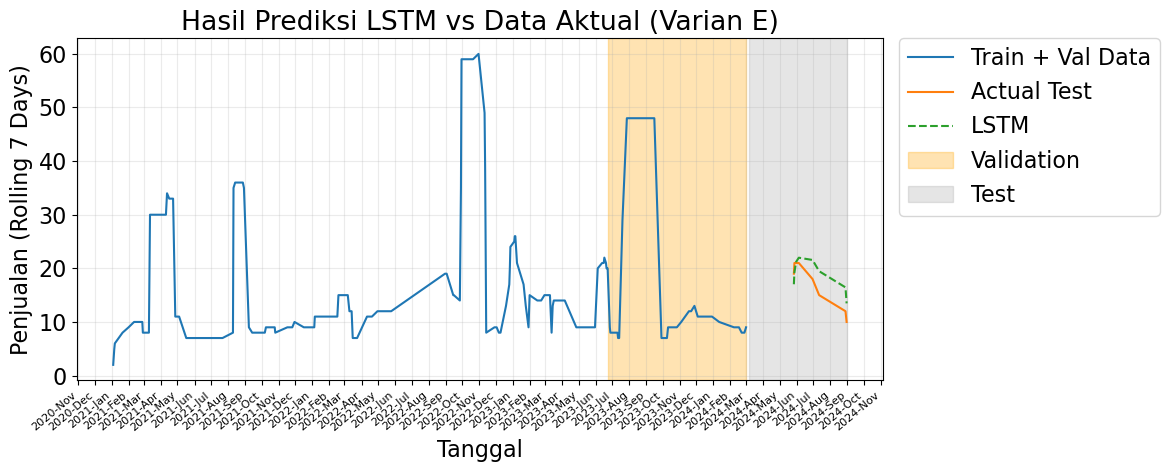

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))

train_val_df = pd.concat([train_df, val_df], ignore_index=True)
ax.plot(train_val_df["Tgl. Mohon"], train_val_df["rolling_7days"], label="Train + Val Data")
ax.plot(test_df["Tgl. Mohon"][sequence_length:], y_test_inverse, label="Actual Test")
ax.plot(test_df["Tgl. Mohon"][sequence_length:], predictions_inverse, linestyle="--", label="LSTM")


# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Hasil Prediksi LSTM vs Data Aktual (Varian E)")
ax.grid("on")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(8)
    label.set_horizontalalignment('right')

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()


In [32]:
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / np.where(y_test_inverse == 0, 1, y_test_inverse))) * 100
mse = mean_squared_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mse)

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE  : 2.61
MAPE : 18.21%
MSE  : 9.05
RMSE : 3.01


In [33]:
# Hitung MAE dari model naive (Last Observation)
naive_forecast = y_test_inverse[:-1]  # prediksi pakai nilai sebelumnya
true_values = y_test_inverse[1:]      # nilai aktual mulai dari t+1

mae_naive = mean_absolute_error(true_values, naive_forecast)
mae_model = mean_absolute_error(y_test_inverse, predictions_inverse)
# MASE
mase = mae_model / mae_naive
print(f"MASE : {mase:.2f}")

MASE : 1.40
